##### → Import Packages:

In [1]:
import numpy as np
import random
import math
from matplotlib import pyplot as plt

from graphviz import Digraph
from graphviz import Source

import torch


print(f'PyTorch Version: {torch.__version__}.')
print(f'NumPy Version: {np.__version__}.')

PyTorch Version: 2.6.0+cpu.
NumPy Version: 2.1.3.


##### → Design Data Structure and Computational Graph: how does a node look.

In [3]:
class Value:
    def __init__(self, data, _children=[], _operation='', label=''):
        self.data = data
        self.grad = 0.0    # No effect when an instance (=object) has been just created.
        self.label = label

        # These are for backprop.
        self._children = _children
        self._operation = _operation
        self._backward = lambda: None # blank function.
        '''
        • The left nodes cannot call not  _backward method.
        • It is an empty function when an instance (=object) has just been created.
        • "def v(): None" and "v = lambda: None" represent exactly same function.
        '''
    #end-def

    def __repr__(self,):
        return f'Value(data={self.data:0.4f}, grad={self.grad:0.4f}, label={self.label})'
    #end-def

    def __add__(self, other):
        '''
        • Operation: When we ask to calculate "a+b," 
        Python internally calls "a.__add__(b)."
        '''
        other = other if isinstance(other, Value) else Value(data=other)
        
        output = Value(data=self.data + other.data,
                     _children=[self, other],
                     _operation='+')

        def _backward():
            self.grad  += 1.0 * output.grad
            other.grad += 1.0 * output.grad
        #end-def
        output._backward = _backward
        # This should not be _backward(); otherwise, it calls each time.
        return output
    #end-def

    def __radd__(self, other):
        return self + other
    #end-def

    def __mul__(self, other):
        '''
        Operation: When we ask to calculate "a*b," 
        Python internally calls "a.__mul__(b)."
        '''
        other = other if isinstance(other, Value) else Value(data=other)

        output = Value(data=self.data * other.data,
                     _children=[self, other],
                     _operation='*')
        
        def _backward():
            self.grad  += other.data * output.grad
            other.grad += self.data  * output.grad

            # print(f'''
            #     self.data: {self.data}, self.grad: {self.grad},
            #     other.data: {other.data}, self.grad: {other.grad}, 
            #     output.data: {output.data}, output.grad {output.grad}
            # ''')
        #end-def
        output._backward = _backward
        # This should not be _backward(); otherwise, it calls each time.
        return output
    #end-def

    def __rmul__(self, other):
        return self * other
    #end-def

    def __neg__(self):
        return self * (-1.0)
    #end-def

    def __sub__(self, other):
        return self + (-other)
    #end-def

    def __rsub__(self, other):
        return (-self) + other
    #end-def

    def __pow__(self, other):
        assert isinstance(other, (int, float)), '__pow__ supports solely int and float.'
        
        output = Value(self.data ** other, _children=[self,], _operation=f'{self.data}^{other}')

        def _backward():
            self.grad += (other * (self.data ** (other - 1.0))) * output.grad
        #end-def
        output._backward = _backward
        
        return output
    #end-def

    def __truediv__(self, other):
        # z = a(=2) / 2.5 = 0.8
        return self * (other ** (-1.0))
    #end-def

    def __rtruediv__(self, other):
        # z = 2.5 / a(=2) = 1.25
        return (self**(-1.0)) * other

    def tanh(self):
        x = self.data
        
        # exponent_portion = math.exp(2.0*x) # exponet_portion = (2.0*x).exp()

        # data = (exponent_portion - 1) / (exponent_portion + 1)

        data = math.tanh(x)

        output = Value(data=data, _children=[self], _operation='tanh( )')
        
        def _backward():
            self.grad += (1.0-(output.data**2.0)) * output.grad
        #end-def
        output._backward = _backward

        return output
    #end-def

    def ReLU(self):
        x = self.data
        output = Value(data=x if x>0 else 0.0, _children=[self,], _operation='ReLU( )')
        
        def _backward():
            self.grad += (1.0 if x>0 else 0.0) * output.grad
        #end-def
        output._backward = _backward
        
        return output
    #end-def

    def log(self):
        output = Value(data=math.log(self.data), _children=[self,], _operation='logₑ( )')
        
        def _backward():
            self.grad += (1.0/self.data) * output.grad
        #end-def
        output._backward = _backward
        
        return output
    #end-def

    def sigmoid(self):
        x = self.data
        
        sigmoid = 1.0 / (1.0 + math.exp(-x))

        output = Value(data=sigmoid, _children=[self,], _operation='sigmoid( )')

        def _backward():
            self.grad += (sigmoid * (1.0 - sigmoid)) * output.grad
        #end-def

        output._backward = _backward
        return output
    #end-def

    def exp(self,):
        x = math.exp(self.data)
        output = Value(data=x, _children=[self,], _operation='exp( )')

        def _backward():
            self.grad += x * output.grad
        #end-def
        output._backward = _backward
        return output
    #end-def

    def backward(self):
        ordered_topology = []
        visited_nodes = []

        def build_topology(node):
            if node not in visited_nodes:
                visited_nodes.append(node)

                # children = node._children
                # child = 0
                # while child<len(children):
                #     build_topology(children[child])
                #     child += 1
                # #end-while

                for child in node._children:
                    build_topology(child)
                #end-for
                
                ordered_topology.append(node)
            #end-if/else
        #end-def
        build_topology(self)

        self.grad = 1.0
        for node in reversed(ordered_topology):
            node._backward()
        #end-def
    #end-def
#end-def

##### → Lookup the Computational Graph: connect_dot(loss)

In [4]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._children:
                edges.add((child, v))
                build(child)
            #end-for
        #end-if/else
    #end-def
    build(root)
    return nodes, edges
#end-def

def connect_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "%s | {data = %.4f} | {grad = %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._operation:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._operation, label = n._operation)
            # and connect this node to it
            dot.edge(uid + n._operation, uid)
        #end-else/if
    #end-for

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._operation)
    #end-for

    return dot
#end-def

##### // Test Backprop on Computational Graph / Test Engine: MicroGrad vs PyTorch

In [6]:
def sanity_check_1():
    x = Value(-4.0)
    z = 2 * x + 2 + x
    q = z.ReLU() + z * x
    h = (z * z).ReLU()
    y = h + q + q * x
    y.backward()
    x_mg, y_mg = x, y

    # Value(data=-4.0000, grad=46.0000, label=) Value(data=-20.0000, grad=1.0000, label=)
    # print(x_mg.data, y_mg.data)

    x = torch.tensor([-4.0], requires_grad = True)
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    x_pt, y_pt = x, y

    # tensor([-4.], requires_grad=True) tensor([-20.], grad_fn=<AddBackward0>)
    # print(x_pt.data.item(), y_pt.data.item())

    # Forward pass went well, if it works.
    assert y_mg.data == y_pt.data.item()
    # Backward pass went well, if it works.
    assert x_mg.grad == x_pt.grad.item()
#end-def

sanity_check_1()



def sanity_check_2():
    a = Value(-4.0)
    b = Value(2.0)
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    d += d * 2 + (b + a).ReLU()
    d += 3 * d + (b - a).ReLU()
    e = c - d
    f = e**2
    g = f / 2.0
    g += 10.0 / f
    g.backward()
    a_mg, b_mg, g_mg = a, b, g

    a = torch.tensor([-4.0], requires_grad = True)
    b = torch.tensor([2.0],  requires_grad = True)
    c = a + b
    d = a * b + b**3
    c = c + c + 1
    c = c + 1 + c + (-a)
    d = d + d * 2 + (b + a).relu()
    d = d + 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g = g + 10.0 / f
    g.backward()
    a_pt, b_pt, g_pt = a, b, g

    # Forward pass went well, if it works.
    # print(g_mg.data, g_pt.data.item())
    assert abs(g_mg.data == g_pt.data.item()) < (1/1000)
    

    # backward pass went well:
    assert abs(a_mg.grad == a_pt.grad.item()) < (1/1000)
    assert abs(b_mg.grad == b_pt.grad.item()) < (1/1000)
#end-def

sanity_check_2()

##### // Check MicroGrad_Engine:

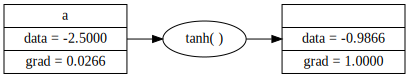

In [8]:
a = Value(-2.5, label='a')

z = a.tanh()

# print(z)
z.backward()
connect_dot(z)

##### → Network:

In [5]:
class Module:
    def zero_grad(self):
        for parameter in self.parameters():
            parameter.grad = 0.0
        #end-for
    #end-def
    def parameters(self):
        return []
    #end-def
#end-class

class Neuron:
    def __init__(self, nin: int, non_linearity=True):
        # nin   [number_of_connections_of_each_neuron, number_of_dimenstions]: 3
        # 'nin' indicates how many input(s) are connected to a [single] neuron.

        self.weights       = [Value(data=random.uniform(-1, 1.0) * (nin**(-0.5)), label=f'w{_+1}') for _ in range(nin)]  # Value(data=[-1, 1))
        self.b             = Value(data=0.0, label='b')
        self.non_linearity = non_linearity
    #end-def
    
    def __call__(self, xs):
        # z = Σ(w[i] * x[i]) + b
        # a = f(z)
        
        z = sum([(w*x) for w, x in zip(self.weights, xs)]) + self.b # pre-activation
        # a = z.tanh() # passed through activaton function (=non linearity).
        # a.label = 'a (=output for each sample)'
        return z.ReLU() if self.non_linearity == True else z
    #end-def

    def parameters(self):
        return self.weights + [self.b]
    #end-def
#end-class


class Layer:
    '''In a layer, every neuron is connected to inputs (nin), but 
    no neuron is connected to each other.'''
    def __init__(self, nin: int, nout: int, non_linearity):
        # nin   [number_of_connections_of_each_neuron, number_of_dimenstions]: 3
        # nout  [number_of_neurons_of_each_layer]: 5
        # nouts [neurons_of_each_layer]: [4, 4, 1]

        self.neurons = [Neuron(nin, non_linearity) for _ in range(nout)]
    #end-def

    def __call__(self, xs):
        outputs = [neuron(xs) for neuron in self.neurons]
        return outputs if len(outputs) != 1 else outputs[0]
    #end-def

    def parameters(self):
        # params = [neuron.parameters() for p in neuron for neuron in self.neurons]
        # return params
        # def parameters(self):
            # return self.weights + [self.b]
        # params = []
        # for neuron in self.neurons:
        #     for parameter in neuron.parameters():
        #         params.append(parameter)
        #     #end-for
        # #end
        return [parameter for neuron in self.neurons for parameter in neuron.parameters()]
    #end-def
#end-class


class MLP(Module):
    def __init__(self, nin, nouts):
        # nin   [number_of_connections_of_each_neuron, number_of_dimenstions]: 3
        # nout  [number_of_neurons_of_each_layer]: 5
        # nouts [neurons_of_each_layer]: [4, 4, 1]

        layer_nin_nout = [nin] + nouts

        self.layers = [
            Layer(layer_nin_nout[i], layer_nin_nout[i+1], non_linearity =(True if i!=len(nouts)-1 else False))
            for i in range(len(nouts))
        ]
    #end-def 

    def __call__(self, xs):
        # return [layer(xs) for layer in self.layers]
        for layer in self.layers:
            xs = layer(xs)
        #end-for
        return xs
    #end-def

    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]
    #end-def
#end-class

##### → Training 1: four samples

In [249]:
X = [
    [Value(2.0, label='x1 [sample #1]'),   Value(3.0,  label='x2 [sample #1]'),  Value(-1.0, label='x3 [sample #1]')],
    [Value(3.0, label='x1 [sample #2]'),   Value(-1.0, label='x2 [sample #2]'),  Value(0.5,  label='x3 [sample #2]')],
    [Value(0.5, label='x1 [sample #3]'),   Value(1.0,  label='x2 [sample #3]'),  Value(1.0,  label='x3 [sample #3]')],
    [Value(1.0, label='x1 [sample #4]'),   Value(1.0,  label='x2 [sample #4]'),  Value(-1.0, label='x3 [sample #4]')],
]

ys = [1.0, -1.0, -1.0, 1.0] #desired outputs

In [250]:
nin = 3   # dimention of X
nouts = [4, 4, 1]

# nin   [number_of_connections_of_each_neuron, number_of_dimenstions]: 3
# nout  [number_of_neurons_of_each_layer]: 5
# nouts [neurons_of_each_layer]: [4, 4, 1]

model = MLP(nin, nouts)

# parameters = model.parameters()
# number_of_parameters = len(parameters)
# print(number_of_parameters) # 41

###### `Forward pass:`

In [197]:
ysp = [model(xs) for xs in X]

loss = sum([(y - yp)**2.0 for y, yp in zip(ys, ysp)])
print(f'loss: {loss}')

AttributeError: 'Neuron' object has no attribute 'non_linearity'

###### `Backward pass:`

In [ ]:
for parameter in model.parameters():
    parameter.grad = 0.0
#end-for

loss.backward()

###### `Update parameters:`

In [ ]:
learning_rate = 1.0/1000.0

for parameter in model.parameters():
    parameter.data = parameter.data - (learning_rate * parameter.grad)
#end-for

###### `Forward pass`, `Backward pass` and `Update parameters`:

In [251]:
number_of_epochs = 350+1
learning_rate = 1.0/1000.0


def MSE(ysp):
    return sum([(y - yp)**2.0 for y, yp in zip(ys, ysp)]) / len(ys)
#end-def

losses = []
for epoch in range(number_of_epochs):
    # Forward pass:
    ysp = [model(xs) for xs in X]
    loss = MSE(ysp)
    
    # Backward pass:
    for parameter in model.parameters():
        parameter.grad = 0.0
    #end-for
    loss.backward()

    # Update parameters:
    for parameter in model.parameters():
        parameter.data = parameter.data - (learning_rate * parameter.grad)
    #end-for

    # Visualize:
    if epoch%50==0:
        print(f'loss: {loss.data:0.4f} at epoch {epoch}')
    #end-if/else

    losses.append(loss.data)
#end-for

loss: 0.7005 at epoch 0
loss: 0.5570 at epoch 50
loss: 0.4329 at epoch 100
loss: 0.3312 at epoch 150
loss: 0.2507 at epoch 200
loss: 0.1880 at epoch 250
loss: 0.1400 at epoch 300
loss: 0.1036 at epoch 350


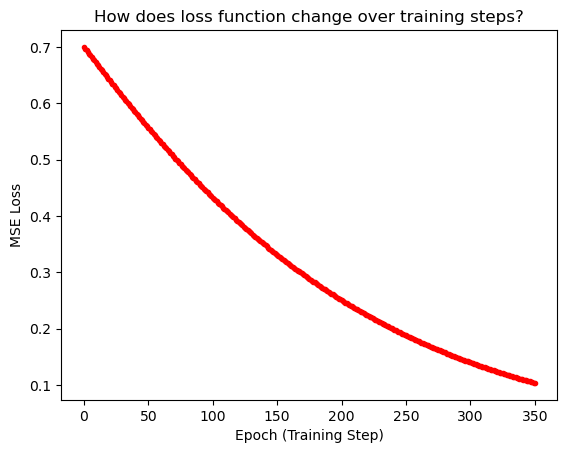

In [252]:
def loss_plot(losses):
    plt.title('How does loss function change over training steps?', fontsize=12)

    plt.plot(losses, color='red', marker='.', linewidth=2.0)
    plt.xlabel('Epoch (Training Step)', fontsize=10)
    plt.ylabel('MSE Loss', fontsize=10)

    plt.savefig(fname='output/Loss_Function_over_Training_Steps.png', dpi=600)
    plt.show()
#end-def

loss_plot(losses)

##### → Training 2: Grok's Example:

In [262]:
# Generate a sample dataset with 1000 samples and 5 features
n_samples = 300
X = np.random.randn(n_samples, 5)
y = np.zeros(n_samples, dtype=int)
y[X[:, 0] < -1] = 0  # Class 0 if first feature < -1
y[(X[:, 0] >= -1) & (X[:, 0] < 1)] = 1  # Class 1 if -1 <= first feature < 1
y[X[:, 0] >= 1] = 2  # Class 2 if first feature >= 1

# Split dataset into training (80%), validation (10%), and test (10%) sets
indices = np.arange(n_samples)
np.random.shuffle(indices)
train_size = int(0.8 * n_samples)
val_size = int(0.1 * n_samples)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

X_train = X[train_indices]
y_train = y[train_indices]
X_val = X[val_indices]
y_val = y[val_indices]
X_test = X[test_indices]
y_test = y[test_indices]

# Initialize the MLP with input size 5, four hidden layers of 8 neurons, and 3 output classes
model = MLP(5, [8, 8, 8, 3])

# Set training hyperparameters
learning_rate = 0.01
num_epochs = 100
batch_size = 16

# Function to compute accuracy on a dataset
def compute_accuracy(model, X, y):
    correct = 0
    for x, true_y in zip(X, y):
        x_val = [Value(feature) for feature in x]
        logits = model(x_val)
        pred = np.argmax([logit.data for logit in logits])
        if pred == true_y:
            correct += 1
    return correct / len(y)

# Training loop
for epoch in range(num_epochs):
    # Shuffle training data
    train_perm = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[train_perm]
    y_train_shuffled = y_train[train_perm]
    
    # Process mini-batches
    for i in range(0, len(X_train), batch_size):
        end_i = min(i + batch_size, len(X_train))
        batch_X = X_train_shuffled[i:end_i]
        batch_y = y_train_shuffled[i:end_i]
        
        # Compute cross-entropy loss for the batch
        total_loss = Value(0.0)
        for x, y in zip(batch_X, batch_y):
            x_val = [Value(feature) for feature in x]
            logits = model(x_val)
            exp_logits = [logit.exp() for logit in logits]
            sum_exp = Value(0.0)
            for el in exp_logits:
                sum_exp += el
            probs = [el / sum_exp for el in exp_logits]
            loss = -probs[y].log()
            total_loss += loss
        
        average_loss = total_loss / len(batch_X)
        
        # Zero gradients
        model.zero_grad()
        
        # Backpropagate
        average_loss.backward()
        
        # Update parameters
        for p in model.parameters():
            p.data -= learning_rate * p.grad
    
    # Compute and print validation accuracy
    val_accuracy = compute_accuracy(model, X_val, y_val)
    print(f"Epoch {epoch + 1}, Val Accuracy: {val_accuracy:.4f}")

# Evaluate on test set
test_accuracy = compute_accuracy(model, X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1, Val Accuracy: 0.5333
Epoch 2, Val Accuracy: 0.5667
Epoch 3, Val Accuracy: 0.6333
Epoch 4, Val Accuracy: 0.6667
Epoch 5, Val Accuracy: 0.6667
Epoch 6, Val Accuracy: 0.7000
Epoch 7, Val Accuracy: 0.7000
Epoch 8, Val Accuracy: 0.7333
Epoch 9, Val Accuracy: 0.7333
Epoch 10, Val Accuracy: 0.7333
Epoch 11, Val Accuracy: 0.7000
Epoch 12, Val Accuracy: 0.7000
Epoch 13, Val Accuracy: 0.7000
Epoch 14, Val Accuracy: 0.7000


KeyboardInterrupt: 

In [267]:
# for k in range(1, 20):
#     lr = 1.0 - ((0.9*k)/100.0)
#     print(lr)

##### Karpaty's Assignment on MicroGrad:

In [123]:
model = MLP(4, [5, 3])
# print(len(model.parameters()))

xs = [1.0, 2.0, 3.0]


X = [
    [1.0, 2.0, 3.0, 1],
    [-1.0, 2.0, -3.0, 1],
    [1.0, 2.0, -3.0, 1],
    [-1.0, 2.0, 3.0, 0],
]


Y = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 1],
]

Yp = [model(xs) for xs in X]

print(Yp)
# ysp = [Value(data=0.0), Value(data=3.0), Value(data=-2.0), Value(data=1.0)]

[[Value(data=0.5915, grad=0.0000, label=), Value(data=1.0591, grad=0.0000, label=), Value(data=-0.6549, grad=0.0000, label=)], [Value(data=1.8970, grad=0.0000, label=), Value(data=-1.6331, grad=0.0000, label=), Value(data=0.2792, grad=0.0000, label=)], [Value(data=0.7984, grad=0.0000, label=), Value(data=-1.1234, grad=0.0000, label=), Value(data=0.2001, grad=0.0000, label=)], [Value(data=1.0400, grad=0.0000, label=), Value(data=1.7956, grad=0.0000, label=), Value(data=-1.0599, grad=0.0000, label=)]]


In [134]:
len(Yp)

4

In [121]:
V = [[1, 3, 3], [1, 2, 3]]

print(len(V))

2


In [135]:
def softmax(logits):
    # When we have multiples outputs...
    elements = [logit.exp() for logit in logits]
    SUM = sum(elements)
    return [(element/SUM) for element in elements]
#end-def

def NLL(ys, ps):
    return -sum([y*(p+0.00000000001).log() for y, p in zip(ys, ps)])
#end-def

def categorical_cross_entrorpy(Y, Yp):
    losses = []
    for ys, ysp in zip(Y, Yp):
        ps = softmax(ysp)
        losses.append(NLL(ys, ps))
    #end-for
    return sum(losses)/len(Y)
#end-def

loss = categorical_cross_entrorpy(Y, Yp)
print(loss)

Value(data=2.3000, grad=0.0000, label=)


##### → Classify Iris Dataset:

###### Dataset:

In [6]:
# setosa:     [1, 0, 0]
# versicolor: [0, 1, 0]
# virginica:  [0, 0, 1]

Y = [
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0]
]

# Y

X = [
    [5.1, 3.5, 1.4, 0.2],
    [4.9, 3.0, 1.4, 0.2],
    [4.7, 3.2, 1.3, 0.2],
    [4.6, 3.1, 1.5, 0.2],
    [5.0, 3.6, 1.4, 0.2],
    [5.4, 3.9, 1.7, 0.4],
    [4.6, 3.4, 1.4, 0.3],
    [5.0, 3.4, 1.5, 0.2],
    [4.4, 2.9, 1.4, 0.2],
    [4.9, 3.1, 1.5, 0.1],
    [5.4, 3.7, 1.5, 0.2],
    [4.8, 3.4, 1.6, 0.2],
    [4.8, 3.0, 1.4, 0.1],
    [4.3, 3.0, 1.1, 0.1],
    [5.8, 4.0, 1.2, 0.2],
    [5.7, 4.4, 1.5, 0.4],
    [5.4, 3.9, 1.3, 0.4],
    [5.1, 3.5, 1.4, 0.3],
    [5.7, 3.8, 1.7, 0.3],
    [5.1, 3.8, 1.5, 0.3],
    [5.4, 3.4, 1.7, 0.2],
    [5.1, 3.7, 1.5, 0.4],
    [4.6, 3.6, 1.0, 0.2],
    [5.1, 3.3, 1.7, 0.5],
    [4.8, 3.4, 1.9, 0.2],
    [5.0, 3.0, 1.6, 0.2],
    [5.0, 3.4, 1.6, 0.4],
    [5.2, 3.5, 1.5, 0.2],
    [5.2, 3.4, 1.4, 0.2],
    [4.7, 3.2, 1.6, 0.2],
    [4.8, 3.1, 1.6, 0.2],
    [5.4, 3.4, 1.5, 0.4],
    [5.2, 4.1, 1.5, 0.1],
    [5.5, 4.2, 1.4, 0.2],
    [4.9, 3.1, 1.5, 0.1],
    [5.0, 3.2, 1.2, 0.2],
    [5.5, 3.5, 1.3, 0.2],
    [4.9, 3.1, 1.5, 0.1],
    [4.4, 3.0, 1.3, 0.2],
    [5.1, 3.4, 1.5, 0.2],
    [5.0, 3.5, 1.3, 0.3],
    [4.5, 2.3, 1.3, 0.3],
    [4.4, 3.2, 1.3, 0.2],
    [5.0, 3.5, 1.6, 0.6],
    [5.1, 3.8, 1.9, 0.4],
    [4.8, 3.0, 1.4, 0.3],
    [5.1, 3.8, 1.6, 0.2],
    [4.6, 3.2, 1.4, 0.2],
    [5.3, 3.7, 1.5, 0.2],
    [5.0, 3.3, 1.4, 0.2],
    [7.0, 3.2, 4.7, 1.4],
    [6.4, 3.2, 4.5, 1.5],
    [6.9, 3.1, 4.9, 1.5],
    [5.5, 2.3, 4.0, 1.3],
    [6.5, 2.8, 4.6, 1.5],
    [5.7, 2.8, 4.5, 1.3],
    [6.3, 3.3, 4.7, 1.6],
    [4.9, 2.4, 3.3, 1.0],
    [6.6, 2.9, 4.6, 1.3],
    [5.2, 2.7, 3.9, 1.4],
    [5.0, 2.0, 3.5, 1.0],
    [5.9, 3.0, 4.2, 1.5],
    [6.0, 2.2, 4.0, 1.0],
    [6.1, 2.9, 4.7, 1.4],
    [5.6, 2.9, 3.6, 1.3],
    [6.7, 3.1, 4.4, 1.4],
    [5.6, 3.0, 4.5, 1.5],
    [5.8, 2.7, 4.1, 1.0],
    [6.2, 2.2, 4.5, 1.5],
    [5.6, 2.5, 3.9, 1.1],
    [5.9, 3.2, 4.8, 1.8],
    [6.1, 2.8, 4.0, 1.3],
    [6.3, 2.5, 4.9, 1.5],
    [6.1, 2.8, 4.7, 1.2],
    [6.4, 2.9, 4.3, 1.3],
    [6.6, 3.0, 4.4, 1.4],
    [6.8, 2.8, 4.8, 1.4],
    [6.7, 3.0, 5.0, 1.7],
    [6.0, 2.9, 4.5, 1.5],
    [5.7, 2.6, 3.5, 1.0],
    [5.5, 2.4, 3.8, 1.1],
    [5.5, 2.4, 3.7, 1.0],
    [5.8, 2.7, 3.9, 1.2],
    [6.0, 2.7, 5.1, 1.6],
    [5.4, 3.0, 4.5, 1.5],
    [6.0, 3.4, 4.5, 1.6],
    [6.7, 3.1, 4.7, 1.5],
    [6.3, 2.3, 4.4, 1.3],
    [5.6, 3.0, 4.1, 1.3],
    [5.5, 2.5, 4.0, 1.3],
    [5.5, 2.6, 4.4, 1.2],
    [6.1, 3.0, 4.6, 1.4],
    [5.8, 2.6, 4.0, 1.2],
    [5.0, 2.3, 3.3, 1.0],
    [5.6, 2.7, 4.2, 1.3],
    [5.7, 3.0, 4.2, 1.2],
    [5.7, 2.9, 4.2, 1.3],
    [6.2, 2.9, 4.3, 1.3],
    [5.1, 2.5, 3.0, 1.1],
    [5.7, 2.8, 4.1, 1.3],
    [6.3, 3.3, 6.0, 2.5],
    [5.8, 2.7, 5.1, 1.9],
    [7.1, 3.0, 5.9, 2.1],
    [6.3, 2.9, 5.6, 1.8],
    [6.5, 3.0, 5.8, 2.2],
    [7.6, 3.0, 6.6, 2.1],
    [4.9, 2.5, 4.5, 1.7],
    [7.3, 2.9, 6.3, 1.8],
    [6.7, 2.5, 5.8, 1.8],
    [7.2, 3.6, 6.1, 2.5],
    [6.5, 3.2, 5.1, 2.0],
    [6.4, 2.7, 5.3, 1.9],
    [6.8, 3.0, 5.5, 2.1],
    [5.7, 2.5, 5.0, 2.0],
    [5.8, 2.8, 5.1, 2.4],
    [6.4, 3.2, 5.3, 2.3],
    [6.5, 3.0, 5.5, 1.8],
    [7.7, 3.8, 6.7, 2.2],
    [7.7, 2.6, 6.9, 2.3],
    [6.0, 2.2, 5.0, 1.5],
    [6.9, 3.2, 5.7, 2.3],
    [5.6, 2.8, 4.9, 2.0],
    [7.7, 2.8, 6.7, 2.0],
    [6.3, 2.7, 4.9, 1.8],
    [6.7, 3.3, 5.7, 2.1],
    [7.2, 3.2, 6.0, 1.8],
    [6.2, 2.8, 4.8, 1.8],
    [6.1, 3.0, 4.9, 1.8],
    [6.4, 2.8, 5.6, 2.1],
    [7.2, 3.0, 5.8, 1.6],
    [7.4, 2.8, 6.1, 1.9],
    [7.9, 3.8, 6.4, 2.0],
    [6.4, 2.8, 5.6, 2.2],
    [6.3, 2.8, 5.1, 1.5],
    [6.1, 2.6, 5.6, 1.4],
    [7.7, 3.0, 6.1, 2.3],
    [6.3, 3.4, 5.6, 2.4],
    [6.4, 3.1, 5.5, 1.8],
    [6.0, 3.0, 4.8, 1.8],
    [6.9, 3.1, 5.4, 2.1],
    [6.7, 3.1, 5.6, 2.4],
    [6.9, 3.1, 5.1, 2.3],
    [5.8, 2.7, 5.1, 1.9],
    [6.8, 3.2, 5.9, 2.3],
    [6.7, 3.3, 5.7, 2.5],
    [6.7, 3.0, 5.2, 2.3],
    [6.3, 2.5, 5.0, 1.9],
    [6.5, 3.0, 5.2, 2.0],
    [6.2, 3.4, 5.4, 2.3],
    [5.9, 3.0, 5.1, 1.8]
]

len(Y)

150

###### Dataset shuffle and split into train, validation and test:

In [7]:
from sklearn.utils import shuffle

X, Y = shuffle(X, Y, random_state=42)

In [8]:
print(len(X))
print(len(Y))

150
150


In [9]:
from sklearn.model_selection import train_test_split

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Step 1: Split into train+val and test
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, 
    test_size=test_ratio,
    random_state=42,
    shuffle=False,
)


val_relative_ratio = val_ratio / (train_ratio + val_ratio)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=val_relative_ratio,
    random_state=42,
    shuffle=False,
)

# Verify the sizes
print(f"Total samples: {len(X)}")
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

Total samples: 150
Training set: 104 samples (69.3%)
Validation set: 23 samples (15.3%)
Test set: 23 samples (15.3%)


###### NN:

In [22]:
model = MLP(4, [10, 3])

# Yp = [model(xs) for xs in X_train]

# print(Yp)

In [23]:
# len(Yp[0])

In [24]:
def softmax(logits):
    # When we have multiples outputs...
    elements = [logit.exp() for logit in logits]
    SUM = sum(elements)
    return [(element/SUM) for element in elements]
#end-def

def NLL(ys, ps):
    return -sum([y*(p+0.00000000001).log() for y, p in zip(ys, ps)])
#end-def

def categorical_cross_entrorpy(Y, Yp):
    losses = []
    for ys, ysp in zip(Y, Yp):
        ps = softmax(ysp)
        losses.append(NLL(ys, ps))
    #end-for
    return sum(losses)/len(Y)
#end-def

# loss = categorical_cross_entrorpy(Y, Yp)
# print(loss)

In [25]:
# connect_dot(loss)

In [26]:
n_epochs = 1000+1
lr = 1e-2

losses_train = []
losses_val = []

for epoch in range(n_epochs):
    # Forward pass: training
    Y_train_prediction = [model(xs) for xs in X_train]
    loss_train = categorical_cross_entrorpy(Y_train, Y_train_prediction)

    Y_val_prediction = [model(xs) for xs in X_val]
    loss_val = categorical_cross_entrorpy(Y_val, Y_val_prediction)

    # Backward pass:
    model.zero_grad()
    loss_train.backward()

    # Update:
    for parameter in model.parameters():
        parameter.data -= lr * parameter.grad
    #end-for

    print(f'When epoch is {epoch+1}, training loss is {loss_train.data:0.5f} and validation loss is {loss_val.data:0.5f}.')
    
    losses_train.append(loss_train.data)
    losses_val.append(loss_val.data)
#end-for

When epoch is 1, training loss is 1.92593 and validation loss is 2.31105.
When epoch is 2, training loss is 1.71769 and validation loss is 2.02738.
When epoch is 3, training loss is 1.55910 and validation loss is 1.80892.
When epoch is 4, training loss is 1.43730 and validation loss is 1.64023.
When epoch is 5, training loss is 1.34180 and validation loss is 1.50812.
When epoch is 6, training loss is 1.26519 and validation loss is 1.40284.
When epoch is 7, training loss is 1.20255 and validation loss is 1.31765.
When epoch is 8, training loss is 1.15072 and validation loss is 1.24798.
When epoch is 9, training loss is 1.10754 and validation loss is 1.19120.
When epoch is 10, training loss is 1.07149 and validation loss is 1.14443.
When epoch is 11, training loss is 1.04140 and validation loss is 1.10610.
When epoch is 12, training loss is 1.01645 and validation loss is 1.07473.
When epoch is 13, training loss is 0.99582 and validation loss is 1.04909.
When epoch is 14, training loss is

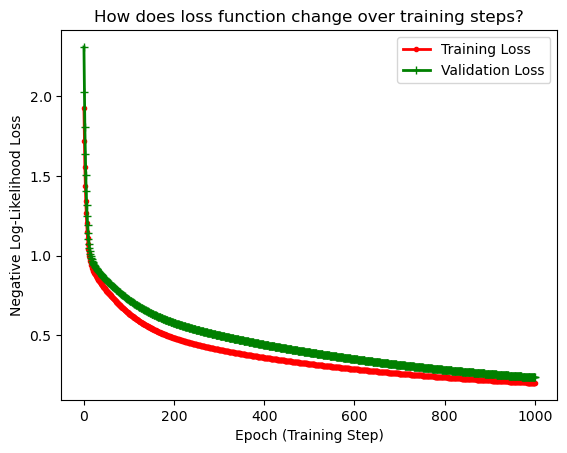

In [27]:
def loss_plot(losses_train, losses_val):
    plt.title('How does loss function change over training steps?', fontsize=12)

    plt.plot(losses_train, color='red', marker='.', linewidth=2.0, label='Training Loss')
    plt.plot(losses_val, color='green', marker='+', linewidth=2.0,  label='Validation Loss')

    plt.xlabel('Epoch (Training Step)', fontsize=10)
    plt.ylabel('Negative Log-Likelihood Loss', fontsize=10)

    plt.legend()

    plt.savefig(fname='output/Loss_Function_over_Training_Steps.png', dpi=600)
    plt.show()
#end-def

loss_plot(losses_train, losses_val)

# def loss_plot(losses):
#     plt.title('How does loss function change over training steps?', fontsize=12)

#     plt.plot(losses, color='red', marker='.', linewidth=2.0)
#     plt.xlabel('Epoch (Training Step)', fontsize=10)
#     plt.ylabel('MSE Loss', fontsize=10)

#     plt.savefig(fname='output/Loss_Function_over_Training_Steps.png', dpi=600)
#     plt.show()
# #end-def

# loss_plot(losses)

###### Test Result:

In [28]:
def accuracy(X, Y):
    Yp = [model(xs) for xs in X]
    # return Yp

    ysp = []
    for yp in Yp:
        ps = softmax(yp)
        p1, p2, p3 = ps[0].data, ps[1].data, ps[2].data
        v = [p1, p2, p3]
        ysp.append(int(np.argmax(v)))
    #end-for

    ys = []
    for i in Y:
        v = np.array(i)
        ys.append(int(np.argmax(v)))
    #end-for

    counter = 0
    for y, yp in zip(ys, ysp):
        if y == yp:
            counter += 1
        #end-def
    #end-for
    
    assert len(ys) == len(ysp)

    return counter / (len(ys))


    # Ysoftmax = softmax(Yp)

    # return Ysoftmax

    # categorical_cross_entrorpy(Y, Yp)
    # ys = []
    # for i in Y:
    #     v = np.array(i)
    #     ys_test.append(int(np.argmax(v)))
    # #end-for

    # ys_test = np.array(ys)
    # ys_test
    # return ys


value = accuracy(X_test, Y_test)
print(f'Test accuracy is {(value*100):0.2f}%.')

Test accuracy is 100.00%.
